In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer


episode_df = pd.read_csv("data/title.episode.tsv", delimiter='\t')
sp_df = episode_df[episode_df["parentTconst"] == "tt0121955"] # get all south park episodes
rating_df = pd.read_csv("data/title.ratings.tsv", delimiter='\t').set_index("tconst")
sp_rating = rating_df.loc[sp_df["tconst"]]

sp_df = pd.concat((sp_df.set_index("tconst"), sp_rating), axis=1)
sp_df["seasonNumber"] = pd.to_numeric(sp_df["seasonNumber"])
sp_df["episodeNumber"] = pd.to_numeric(sp_df["episodeNumber"])
sp_df = sp_df.set_index(["seasonNumber", "episodeNumber"]).sort_index()

sp_df.dropna(inplace=True)
sp_df = sp_df["averageRating"]
sp_df.index.rename(["season", "episode"], inplace=True)

In [5]:
dialoge_df = pd.read_csv("data/All-seasons.csv")

dialoge_df.drop(dialoge_df[dialoge_df["Season"] == "Season"].index, inplace=True)
dialoge_df["Season"] = pd.to_numeric(dialoge_df["Season"])
dialoge_df["Episode"] = pd.to_numeric(dialoge_df["Episode"])
dialoge_df = dialoge_df.set_index(["Season", "Episode"]).sort_index()

dialoge_df

Character                                               Line
Season Episode                                                              
1      1             Boys   School day, school day, teacher's golden ru...\n
       1             Kyle  Ah, damn it! My little brother's trying to fol...
       1              Ike                                     Zeeponanner.\n
       1             Kyle          Ike, you can't come to school with me. \n
       1          Cartman                  Yeah, go home you little dildo.\n
...                   ...                                                ...
18     10            Stan                                            Yeah.\n
       10            Kyle  No matter what we think, it's not just a passi...
       10            Stan                  Yeah, I think that's great too.\n
       10       PewDiePie  Alright bros, it look like we'll have to end i...
       10       PewDiePie                 Oh! That's it bros. Show's over.\n

[70879 rows x 2 columns]

In [6]:
# get word count
# make graph
tokenizer = RegexpTokenizer(r'\w+')


dialoge_df["numWords"] = dialoge_df["Line"].apply(lambda x: len(tokenizer.tokenize(x)))
dialoge_df

Character                                               Line  \
Season Episode                                                                 
1      1             Boys   School day, school day, teacher's golden ru...\n   
       1             Kyle  Ah, damn it! My little brother's trying to fol...   
       1              Ike                                     Zeeponanner.\n   
       1             Kyle          Ike, you can't come to school with me. \n   
       1          Cartman                  Yeah, go home you little dildo.\n   
...                   ...                                                ...   
18     10            Stan                                            Yeah.\n   
       10            Kyle  No matter what we think, it's not just a passi...   
       10            Stan                  Yeah, I think that's great too.\n   
       10       PewDiePie  Alright bros, it look like we'll have to end i...   
       10       PewDiePie                 Oh! That's it bros. Show's over.\n   

                numWords  
Season Episode            
1      1               8  
       1              14  
       1               1  
       1               9  
       1               6  
...                  ...  
18     10              1  
       10             30  
       10              7  
       10             33  
       10              8  

[70879 rows x 3 columns]

In [7]:
dialoge_df.index.rename(["season", "episode"], inplace=True)
dialoge_df.columns = (["character", "line", "num_words"])
dialoge_df


character                                               line  \
season episode                                                                 
1      1             Boys   School day, school day, teacher's golden ru...\n   
       1             Kyle  Ah, damn it! My little brother's trying to fol...   
       1              Ike                                     Zeeponanner.\n   
       1             Kyle          Ike, you can't come to school with me. \n   
       1          Cartman                  Yeah, go home you little dildo.\n   
...                   ...                                                ...   
18     10            Stan                                            Yeah.\n   
       10            Kyle  No matter what we think, it's not just a passi...   
       10            Stan                  Yeah, I think that's great too.\n   
       10       PewDiePie  Alright bros, it look like we'll have to end i...   
       10       PewDiePie                 Oh! That's it bros. Show's over.\n   

                num_words  
season episode             
1      1                8  
       1               14  
       1                1  
       1                9  
       1                6  
...                   ...  
18     10               1  
       10              30  
       10               7  
       10              33  
       10               8  

[70879 rows x 3 columns]

0          Cartman
3          Butters
12           Wendy
13           Liane
4            Randy
1             Stan
10          Gerald
5     Mr. Garrison
2             Kyle
14          Sheila
8           Sharon
6             Chef
9       Mr. Mackey
7            Kenny
11           Jimmy
Name: character, dtype: object


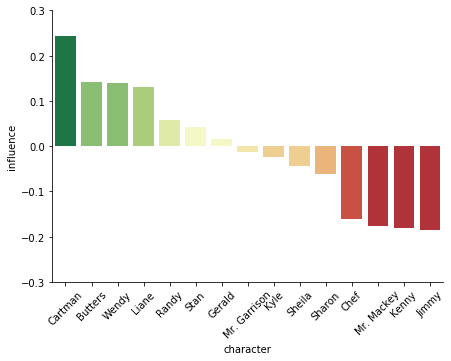

In [17]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

characters = list(dialoge_df["character"].value_counts()[:15].index)
# characters.remove("Kenny")
# characters = ["Stan", "Kenny"]

combined_df = sp_df.copy()
for character in characters:
    character_text_df = dialoge_df[dialoge_df["character"] == character].groupby(["season", "episode"]).sum()["num_words"].to_frame()
    character_text_df.index.name = "id"
    character_text_df.columns = [character]
    combined_df = pd.concat((combined_df, character_text_df), axis=1)

combined_df = combined_df.loc[:18] # dialogue data limited to 18 seasons

fig, ax = plt.subplots()
fig.set_size_inches(70, 50)
sns.despine()
plt.xticks(rotation=45)
ax.set_ylim(-0.3,0.3)
ax.ylable()

coefs = []
for character in characters:
    y = np.array(combined_df["averageRating"])
    X = combined_df[character].to_numpy()

    y = y[~np.isnan(X)]
    X = X[~np.isnan(X)]

    # sns.regplot(X, y, scatter=True)
    model = LinearRegression().fit(X.reshape(-1,1), y)
    # plt.plot(np.linspace(0,2000,2000), model.predict(np.linspace(0,2000,2000).reshape(-1,1)))
    coefs.append(pearsonr(X,y)[0])
# ax.legend(characters)

influence_df = pd.DataFrame({"character": characters, "influence": coefs}).sort_values("influence", ascending=False)

# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

print(influence_df["character"])
sns.barplot(x=influence_df["character"], y=influence_df["influence"], ax=ax, palette=colors_from_values(influence_df["influence"], "RdYlGn"))
fig.savefig("influence.png")

# who should speak the most?
# Shows how the number of words a character speaks correlates to the IMDB score for the first 18 seasons.

